<a href="https://colab.research.google.com/github/saxenabhishek/ConnectX/blob/main/ConnectX_Getting_Started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install kaggle-environments

In [1]:
# 1. Enable Internet in the Kernel (Settings side pane)

# 2. Curl cache may need purged if v0.1.6 cannot be found (uncomment if needed).
# !curl -X PURGE https://pypi.org/simple/kaggle-environments

# ConnectX environment was defined in v0.1.6
!pip -q install 'kaggle-environments'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 837.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Create ConnectX Environment

In [2]:
from kaggle_environments import evaluate, make, utils

env = make("connectx", debug=True)
env.render()

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 179, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 64, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

# Create an Agent

To create the submission, an agent function should be fully encapsulated (no external dependencies).  

When your agent is being evaluated against others, it will not have access to the Kaggle docker image.  Only the following can be imported: Python Standard Library Modules, gym, numpy, scipy, pytorch (1.3.1, cpu only), and more may be added later.



In [10]:
import torch
import torch.nn as nn
import numpy as np
import random
import torch.optim as optim
from collections import deque

In [11]:
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done) -> None:
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int, device='cpu'):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        state = torch.tensor(state, dtype=torch.float32, device=device)
        action = torch.tensor(action, dtype=torch.long, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
        done = torch.tensor(done, dtype=torch.bool, device=device)
        return state, action, reward, next_state, done

    def __len__(self) -> int:
        return len(self.buffer)

In [48]:

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions) -> None:
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.LeakyReLU(),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._get_conv_out((1,6,7)), 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU()
        )

        self.value_fc = nn.Linear(128, 1)
        self.adv_fc = nn.Linear(128, num_actions)

    def _get_conv_out(self, shape) -> int:
        with torch.no_grad():
            o = self.conv(torch.zeros(1, *shape))
            return int(np.prod(o.shape))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv(x)
        x = self.fc(x)

        value = self.value_fc(x)
        advantage = self.adv_fc(x)

        # Combine the two streams
        q_values = value + (advantage - advantage.mean())
        return q_values

DQN((6,7),7)

DQN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=384, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (value_fc): Linear(in_features=128, out_features=1, bias=True)
  (adv_fc): Linear(in_features=128, out_features=7, bias=True)
)

In [76]:
class DQNAgent:
    def __init__(self,
                 input_shape,
                 num_actions,
                 learning_rate=0.003,
                 gamma=0.95,
                 epsilon=0.8,
                 epsilon_decay=0.9995,
                 epsilon_min=0.1,
                 target_update_freq=100
            ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(input_shape, num_actions).to(self.device)

        self.target_network = DQN(input_shape, num_actions).to(self.device)
        self.target_network.load_state_dict(self.model.state_dict())  # Initialize target network

        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.num_actions = num_actions
        self.target_update_freq = target_update_freq
        self.steps_done = 0

    def choose_action(self, observation, configuration):
        if random.random() < self.epsilon:
            return random.choice([c for c in range(configuration.columns) if observation.board[c] == 0])
        else:
            with torch.no_grad():
                state = torch.tensor(observation.board, dtype=torch.float32).view(1, 6, 7).to(self.device)
                q_values = self.model(state).cpu().numpy()[0]
                valid_actions = [c for c in range(configuration.columns) if observation.board[c] == 0]
                if len(valid_actions) == 0:
                    return 1
                action = max(valid_actions, key=lambda c: q_values[c])
                return int(action)

    def train(self, replay_buffer, batch_size=32):
        if len(replay_buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size, device=self.device)

        q_values = self.model(states.view(-1, 6, 7)).gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q_values = self.target_network(next_states.view((-1, 6, 7))).max(1)[0]
            targets = rewards + (1 - dones.float()) * self.gamma * next_q_values

        next_q_values = self.model(next_states.view(-1, 6, 7)).max(1)[0]
        targets = rewards + (1 - dones.float()) * self.gamma * next_q_values

        loss = nn.HuberLoss()(q_values, targets.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        self.steps_done += 1
        if self.steps_done % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.model.state_dict())

        return loss.item()


# Debug/Train your Agent

In [77]:
input_shape = (6, 7) # shape of the board
num_actions = 7 # 7 columns to put coin in

agent = DQNAgent(input_shape, num_actions)
replay_buffer = ReplayBuffer(35*16)
batch_size = 32

reward_history = []
loss_history = []

def mean_reward(rewards):
    return sum(rewards) / float(len(rewards))

In [ ]:
%%time

trainer = env.train([None, "negamax"])

total_episodes = 1000

_r = []
_l = []
observation = trainer.reset()

import tqdm
for episode in tqdm.notebook.tnrange(1, total_episodes):
    if episode % batch_size == 0:
        reward_history.append(mean_reward(_r))
        loss_history.append(mean_reward(_l))
        _r=[]
        _l=[]

    done=False
    while not done:
        action = agent.choose_action(observation, env.configuration)
        new_observation, reward, done, info = trainer.step(action)

        replay_buffer.add(observation.board, action, reward, new_observation.board, done)
        observation = new_observation

        loss_item = agent.train(replay_buffer, batch_size)
        if loss_item != None:
            _l.append(loss_item)

    _r.append(reward)
    trainer.reset()


  0%|          | 0/999 [00:00<?, ?it/s]

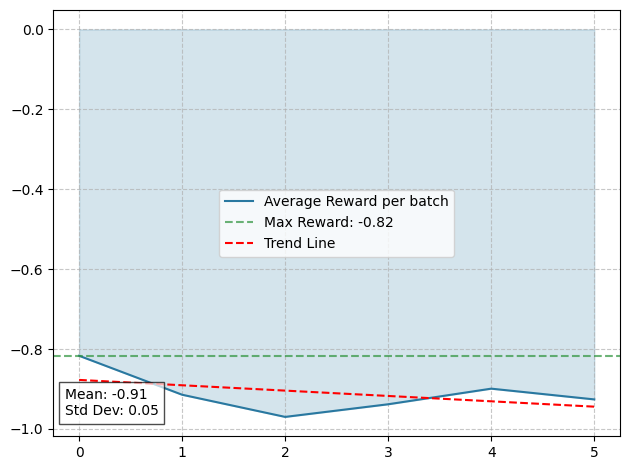

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

def plot_reward_history(reward_history, smoothing=0, show_trend=False, trend_color='orange'):
    """
    Plots reward history with optional smoothing and trend line.
    Args:
        reward_history (list or np.ndarray): The list of rewards.
        smoothing (float): Smoothing factor for Gaussian filter (0 for no smoothing).
        show_trend (bool): If True, adds a trend line to the plot.
        trend_color (str): Color of the trend line.
    """
    if smoothing > 0:
        reward_history = gaussian_filter1d(reward_history, sigma=smoothing)

    # Plotting the reward history
    ax = sns.lineplot(reward_history, label='Average Reward per batch', linewidth=1.5, color='#2978A0')

    # Display mean and standard deviation
    plt.text(0.02, 0.05, f'Mean: {np.mean(reward_history):.2f}\nStd Dev: {np.std(reward_history):.2f}',
             transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    # Highlighting the max reward
    max_reward = max(reward_history)
    plt.axhline(y=max_reward, color='#2E933C', linestyle='--', alpha=0.7,
                label=f'Max Reward: {max_reward:.2f}')

    # Adding a trend line if requested
    if show_trend:
        z = np.polyfit(range(len(reward_history)), reward_history, 1)
        p = np.poly1d(z)
        plt.plot(range(len(reward_history)), p(range(len(reward_history))),
                 linestyle='--', color=trend_color, label='Trend Line')

    # Shading under the curve
    plt.fill_between(range(len(reward_history)), reward_history, alpha=0.2, color='#2978A0')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_reward_history(reward_history, smoothing=1, show_trend=True, trend_color='red')


# Evaluate your Agent

In [68]:
def reward_average(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", reward_average(evaluate("connectx", [agent.choose_action, "random"], num_episodes=100)))
print("My Agent vs Negamax Agent:", reward_average(evaluate("connectx", [agent.choose_action, "negamax"], num_episodes=10)))

My Agent vs Random Agent: 0.11
My Agent vs Negamax Agent: -1.0


In [70]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [73]:
get_win_percentages(agent.choose_action, "negamax")


Agent 1 Win Percentage: 0.02
Agent 2 Win Percentage: 0.98
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [ ]:
import os
os.makedirs("submission", exist_ok=True)

In [ ]:
torch.save(agent.model.state_dict(), "./submission/connect4_dqn.pth")

# Write Submission File



In [ ]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "w" if os.path.exists(file) else "w") as f:
        f.write("""
import torch.nn as nn
import numpy as np
import torch
import sys
import os

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(np.prod(input_shape), 128)
        self.relu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = self.flatten(x)
        x = nn.LeakyReLU()(self.fc1(x))
        x = nn.Softmax(dim=1)(self.fc2(x))
        return x

input_shape = (6, 7)
num_actions = 7

cwd = '/kaggle_simulations/agent/'
if os.path.exists(cwd):
    sys.path.append(cwd)
else:
    cwd = ''

model = None


def inference(observation, configuration):
    global model

    board_tensor = torch.tensor(observation.board, dtype=torch.float32).unsqueeze(0)

    if model == None:
        model = DQN(input_shape, num_actions)
        model_path=cwd + "connect4_dqn.pth"
        model.load_state_dict(torch.load(model_path, weights_only=True))
        model.eval()

    with torch.no_grad():
        q_values = model(board_tensor).cpu().numpy()[0]

    for c in range(configuration.columns):
        if observation.board[c] != 0:
            q_values[c] = -np.inf

    return int(np.argmax(q_values))
        """)
        print(function, "written to", file)

write_agent_to_file(DQN, "./submission/main.py")

<class '__main__.DQN'> written to ./submission/main.py


In [ ]:
%%bash
tar -czfv submission.1.tar.gz -C submission .

# Validate Submission
Play your submission against itself.  This is the first episode the competition will run to weed out erroneous agents.

Why validate? This roughly verifies that your submission is fully encapsulated and can be run remotely.

In [ ]:
import torch.nn as nn
import numpy as np
import torch
import sys

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(np.prod(input_shape), 128)
        self.relu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = self.flatten(x)
        x = nn.LeakyReLU()(self.fc1(x))
        x = nn.Softmax(dim=1)(self.fc2(x))
        return x

input_shape = (6, 7)
num_actions = 7

cwd = '/kaggle_simulations/agent/'
if os.path.exists(cwd):
    sys.path.append(cwd)
else:
    cwd = './submission/'

model = None


def inference(observation, configuration):
    global model

    board_tensor = torch.tensor(observation.board, dtype=torch.float32).unsqueeze(0)

    if model == None:
        model = DQN(input_shape, num_actions)
        model_path=cwd + "connect4_dqn.pth"
        model.load_state_dict(torch.load(model_path, weights_only=True))
        model.eval()

    with torch.no_grad():
        q_values = model(board_tensor).cpu().numpy()[0]

    for c in range(configuration.columns):
        if observation.board[c] != 0:
            q_values[c] = -np.inf

    return int(np.argmax(q_values))

In [ ]:
# Note: Stdout replacement is a temporary workaround.
# import sys
# out = sys.stdout
# submission = utils.read_file("/content/submission.py")
# agent = utils.get_last_callable(submission)
# sys.stdout = out

env = make("connectx", debug=True)
env.run([inference, "negamax"])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")
env.render(mode="ipython")

Success!


# Submit to Competition

1. Commit this kernel.
2. View the commited version.
3. Go to "Data" section and find submission.py file.
4. Click "Submit to Competition"
5. Go to [My Submissions](https://kaggle.com/c/connectx/submissions) to view your score and episodes being played.